In [4]:
# Install required packages
%pip install torch torchvision matplotlib

  Using cached torch-2.8.0-cp310-cp310-win_amd64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp310-cp310-win_amd64.whl.metadata (6.1 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/241.4 MB 2.1 MB/s eta 0:01:55
   ---------------------------------------- 1.0/241.4 MB 2.6 MB/s eta 0:01:31
   ---------------------------------------- 1.6/241.4 MB 2.6 MB/s eta 0:01:32
   -------------

# PINN for Airway Deposition

In [ ]:
# pinndeposition.py
import math, numpy as np
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DTYPE = torch.float32

# ---------- Helpers ----------
def fourier_features(x, n_freq=6):
    # x: (..., d); returns (..., d*(2*n_freq))
    freqs = 2.0**torch.arange(0, n_freq, device=x.device, dtype=x.dtype) * math.pi
    xb = x[..., None, :] * freqs[:, None]  # (..., n_freq, d)
    return torch.cat([torch.sin(xb), torch.cos(xb)], dim=-1).reshape(*x.shape[:-1], -1)

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, width=256, depth=6, act=nn.Tanh()):
        super().__init__()
        layers = [nn.Linear(in_dim, width), act]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), act]
        layers += [nn.Linear(width, out_dim)]
        for m in layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# ---------- PINN ----------
class PINN(nn.Module):
    def __init__(self, ncond=4, dim=2, use_fourier=True):
        super().__init__()
        self.dim = dim
        self.use_fourier = use_fourier
        ff_dim = (2*6)* (dim + 1) if use_fourier else 0  # (x,y) + t
        in_dim = dim + 1 + ncond + ff_dim
        # outputs: u_x,u_y, p, C, m_s (wall var, predicted everywhere but trained at wall points)
        self.model = MLP(in_dim, out_dim=dim + 1 + 1 + 1, width=256, depth=8)  # ux,uy,p,C
        self.ms_head = MLP(in_dim, out_dim=1, width=128, depth=3)              # m_s

    def forward(self, xy, t, cond):
        # xy: (N,2); t:(N,1); cond:(N,4) replicated row-wise
        feats = [xy, t, cond]
        if self.use_fourier:
            feats.append(fourier_features(torch.cat([xy, t], dim=1)))
        h = torch.cat(feats, dim=1)
        out = self.model(h)
        u = out[:, :2]
        p = out[:, 2:3]
        C = out[:, 3:4]
        ms = self.ms_head(h)
        return u, p, C, ms

# ---------- Physics ----------
def cunningham(d_p, lam, A1=1.257, A2=0.4, A3=1.1):
    return 1.0 + (2.0*lam/d_p)*(A1 + A2*torch.exp(-A3*d_p/(2.0*lam)))

def brownian_diffusivity(kB, T, mu, d_p, Cc):
    return (kB*T*Cc)/(3.0*math.pi*mu*d_p)

def particle_relax_time(rho_p, d_p, Cc, mu):
    return (rho_p * d_p**2 * Cc)/(18.0*mu)

def settling_velocity(rho_p, rho, g, d_p, Cc, mu):
    return ((rho_p - rho)*g*d_p**2 * Cc)/(18.0*mu)

# composite deposition velocity (simple but serviceable)
def deposition_velocity(Dp, Dh, Re, Sc, vg, U, Stk, chi=0.1):
    # laminar Sh: use max of 3.66 and developing correlation
    Sh_dev = 1.62*(Re*Sc)**(1/3)
    Sh = torch.maximum(torch.tensor(3.66, device=Dp.device, dtype=Dp.dtype), Sh_dev)
    k_diff = Sh*Dp/Dh
    k_sed = vg.clamp(min=0.0)  # project via geometry if needed
    k_imp = chi*U*Stk/Dh
    return k_diff + k_sed + k_imp

# ---------- Physics Loss Functions ----------
def compute_physics_loss(model, xy, t, cond, rho, mu):
    """Compute physics-informed loss (Navier-Stokes + Convection-Diffusion)"""
    xy.requires_grad_(True)
    t.requires_grad_(True)
    
    u, p, C, ms = model(xy, t, cond)
    
    # Compute gradients
    u_x = torch.autograd.grad(u[:, 0], xy, 
                              grad_outputs=torch.ones_like(u[:, 0]), 
                              create_graph=True)[0]
    u_y = torch.autograd.grad(u[:, 1], xy, 
                              grad_outputs=torch.ones_like(u[:, 1]), 
                              create_graph=True)[0]
    
    u_xx = torch.autograd.grad(u_x[:, 0], xy, 
                               grad_outputs=torch.ones_like(u_x[:, 0]), 
                               create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y[:, 1], xy, 
                               grad_outputs=torch.ones_like(u_y[:, 1]), 
                               create_graph=True)[0][:, 1]
    
    p_grad = torch.autograd.grad(p.sum(), xy, create_graph=True)[0]
    
    # Navier-Stokes equations
    continuity = u_x[:, 0] + u_y[:, 1]  # div(u) = 0
    
    momentum_x = rho * (u[:, 0] * u_x[:, 0] + u[:, 1] * u_x[:, 1]) + p_grad[:, 0] - mu * (u_xx + u_yy)
    momentum_y = rho * (u[:, 0] * u_y[:, 0] + u[:, 1] * u_y[:, 1]) + p_grad[:, 1] - mu * (u_xx + u_yy)
    
    # Convection-diffusion for concentration
    C_grad = torch.autograd.grad(C.sum(), xy, create_graph=True)[0]
    C_t = torch.autograd.grad(C.sum(), t, create_graph=True)[0]
    
    # Simplified diffusion coefficient (should be computed from particle properties)
    D_p = torch.tensor(1e-8, device=device, dtype=DTYPE)  # placeholder
    
    C_xx = torch.autograd.grad(C_grad[:, 0], xy, 
                               grad_outputs=torch.ones_like(C_grad[:, 0]), 
                               create_graph=True)[0][:, 0]
    C_yy = torch.autograd.grad(C_grad[:, 1], xy, 
                               grad_outputs=torch.ones_like(C_grad[:, 1]), 
                               create_graph=True)[0][:, 1]
    
    convection_diffusion = C_t + u[:, 0] * C_grad[:, 0] + u[:, 1] * C_grad[:, 1] - D_p * (C_xx + C_yy)
    
    return continuity, momentum_x, momentum_y, convection_diffusion

# ---------- Collocation & BC sampling (placeholder geometry) ----------
def sample_domain(N):
    # simple 2-D rectangle representing a straight airway: x in [0,L], y in [-R,R]
    L, R = 0.06, 0.01  # 6 cm long, 1 cm half-height (approx tracheal scale)
    xy = torch.rand((N,2), device=device, dtype=DTYPE)
    xy[:,0] = xy[:,0]*L
    xy[:,1] = (xy[:,1]*2-1)*R
    return xy, L, R

def sample_inlet(N_b, R):
    x = torch.zeros((N_b,1), device=device, dtype=DTYPE)
    y = (torch.rand((N_b,1), device=device, dtype=DTYPE)*2-1)*R
    return torch.cat([x,y], dim=1)

def sample_outlet(N_b, L, R):
    x = torch.full((N_b,1), L, device=device, dtype=DTYPE)
    y = (torch.rand((N_b,1), device=device, dtype=DTYPE)*2-1)*R
    return torch.cat([x,y], dim=1)

def sample_walls(N_b, L, R):
    # top and bottom walls
    x_top = torch.rand((N_b//2,1), device=device, dtype=DTYPE)*L
    y_top = torch.full((N_b//2,1), R, device=device, dtype=DTYPE)
    x_bot = torch.rand((N_b - N_b//2,1), device=device, dtype=DTYPE)*L
    y_bot = torch.full((N_b - N_b//2,1), -R, device=device, dtype=DTYPE)
    return torch.cat([torch.cat([x_top,y_top],1), torch.cat([x_bot,y_bot],1)], dim=0)

# ---------- Training setup ----------
def main():
    torch.manual_seed(0)
    model = PINN(ncond=4, dim=2, use_fourier=True).to(device)

    # Physical constants (SI)
    rho = torch.tensor(1.2, device=device, dtype=DTYPE)      # kg/m^3
    mu  = torch.tensor(1.8e-5, device=device, dtype=DTYPE)   # Pa·s
    rho_p = torch.tensor(1200.0, device=device, dtype=DTYPE) # drug particle density kg/m^3
    T = torch.tensor(310.0, device=device, dtype=DTYPE)      # K
    kB = torch.tensor(1.380649e-23, device=device, dtype=DTYPE)
    lam = torch.tensor(65e-9, device=device, dtype=DTYPE)    # air mean free path ~65 nm
    g = torch.tensor(9.81, device=device, dtype=DTYPE)

    # Condition vector (example):
    # breathing rate Q (m^3/s), mean inlet U (m/s), particle size d_p (m), inlet Δp (Pa)
    Q = torch.tensor(30.0/60.0/1000.0, device=device, dtype=DTYPE)  # 30 L/min -> m^3/s
    U_in = torch.tensor(2.0, device=device, dtype=DTYPE)            # example mean velocity
    d_p = torch.tensor(3e-6, device=device, dtype=DTYPE)            # 3 microns
    d_p = d_p.clamp(min=5e-9)  # avoid zero
    dP = torch.tensor(100.0, device=device, dtype=DTYPE)
    cond = torch.stack([Q, U_in, d_p, dP])[None,:]  # (1,4)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

    for it in range(1000):  # Reduced iterations for testing
        optimizer.zero_grad()
        
        # Sample points
        N_domain = 1000
        N_bc = 200
        
        xy_domain, L, R = sample_domain(N_domain)
        t_domain = torch.rand((N_domain, 1), device=device, dtype=DTYPE) * 0.1  # 0.1s time window
        cond_domain = cond.repeat(N_domain, 1)
        
        # Inlet boundary
        xy_inlet = sample_inlet(N_bc, R)
        t_inlet = torch.rand((N_bc, 1), device=device, dtype=DTYPE) * 0.1
        cond_inlet = cond.repeat(N_bc, 1)
        
        # Wall boundary
        xy_wall = sample_walls(N_bc, L, R)
        t_wall = torch.rand((N_bc, 1), device=device, dtype=DTYPE) * 0.1
        cond_wall = cond.repeat(N_bc, 1)
        
        # Physics loss
        continuity, mom_x, mom_y, conv_diff = compute_physics_loss(
            model, xy_domain, t_domain, cond_domain, rho, mu
        )
        
        physics_loss = (continuity**2).mean() + (mom_x**2).mean() + (mom_y**2).mean() + (conv_diff**2).mean()
        
        # Boundary conditions
        u_inlet, p_inlet, C_inlet, _ = model(xy_inlet, t_inlet, cond_inlet)
        u_wall, _, _, _ = model(xy_wall, t_wall, cond_wall)
        
        # Inlet: parabolic velocity profile, fixed concentration
        y_inlet = xy_inlet[:, 1:2]
        u_inlet_target = torch.cat([
            U_in * (1 - (y_inlet/R)**2),  # parabolic u_x
            torch.zeros_like(y_inlet)      # u_y = 0
        ], dim=1)
        C_inlet_target = torch.ones_like(C_inlet)  # unit concentration
        
        bc_inlet_loss = ((u_inlet - u_inlet_target)**2).mean() + ((C_inlet - C_inlet_target)**2).mean()
        
        # Wall: no-slip condition
        bc_wall_loss = (u_wall**2).mean()
        
        # Total loss
        total_loss = physics_loss + 10.0 * (bc_inlet_loss + bc_wall_loss)
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        if it % 100 == 0:
            print(f"Iteration {it}, Loss: {total_loss.item():.6f}")

    print("Training done.")

if __name__ == "__main__":
    main()

Iteration 0, Loss: 32.956268
Iteration 100, Loss: 6.211723
Iteration 100, Loss: 6.211723
Iteration 200, Loss: 6.351690
Iteration 200, Loss: 6.351690
Iteration 300, Loss: 6.208879
Iteration 300, Loss: 6.208879


## **Complete Flow and Theory Analysis of PINN for Airway Deposition**

### **1. Overall Problem & Application**
This code implements a **Physics-Informed Neural Network (PINN)** to simulate **drug particle deposition in human airways**. This is crucial for:
- Designing inhalers and drug delivery systems
- Understanding respiratory disease mechanisms
- Optimizing pharmaceutical formulations

### **2. Mathematical Foundation & Governing Equations**

#### **A. Navier-Stokes Equations (Fluid Flow)**
The code solves the incompressible Navier-Stokes equations for airflow:

**Continuity Equation (Mass Conservation):**


In [ ]:
∇ · u = ∂u_x/∂x + ∂u_y/∂y = 0



**Momentum Equations:**


In [ ]:
ρ(u · ∇)u + ∇p = μ∇²u

Which expands to:
- **X-momentum:** `ρ(u_x ∂u_x/∂x + u_y ∂u_x/∂y) + ∂p/∂x = μ(∂²u_x/∂x² + ∂²u_x/∂y²)`
- **Y-momentum:** `ρ(u_x ∂u_y/∂x + u_y ∂u_y/∂y) + ∂p/∂y = μ(∂²u_y/∂x² + ∂²u_y/∂y²)`

#### **B. Convection-Diffusion Equation (Particle Transport)**
For particle concentration C:


In [ ]:
∂C/∂t + u · ∇C = D_p ∇²C

Where:
- `∂C/∂t + u_x ∂C/∂x + u_y ∂C/∂y = D_p(∂²C/∂x² + ∂²C/∂y²)`

### **3. Particle Physics Theories**

#### **A. Cunningham Slip Correction Factor**


In [ ]:
Cc = 1 + (2λ/d_p)[A1 + A2·exp(-A3·d_p/(2λ))]

- **Theory:** Corrects Stokes drag for small particles where continuum assumption breaks down
- **Constants:** A1=1.257, A2=0.4, A3=1.1 (empirical)
- **λ:** Mean free path of air molecules (~65 nm)

#### **B. Brownian Diffusivity (Einstein-Stokes Equation)**


In [ ]:
D_p = (k_B·T·Cc)/(3π·μ·d_p)

- **Theory:** Random molecular motion causes particle diffusion
- **k_B:** Boltzmann constant
- **T:** Temperature (310K, body temperature)

#### **C. Particle Relaxation Time (Stokes Law)**


In [ ]:
τ_p = (ρ_p·d_p²·Cc)/(18μ)

- **Theory:** Time for particle to adjust to flow changes
- **Critical for:** Impaction mechanisms

#### **D. Settling Velocity (Gravitational)**


In [ ]:
v_g = ((ρ_p - ρ)·g·d_p²·Cc)/(18μ)

- **Theory:** Terminal velocity under gravity
- **Buoyancy correction:** (ρ_p - ρ) accounts for fluid density

#### **E. Deposition Velocity (Composite Model)**


In [ ]:
v_dep = k_diff + k_sed + k_imp

Combines three mechanisms:
1. **Diffusional:** `k_diff = Sh·D_p/D_h`
2. **Sedimentation:** `k_sed = v_g` (projected)
3. **Impaction:** `k_imp = χ·U·Stk/D_h`

### **4. Code Architecture & Flow**

#### **A. Neural Network Structure**

**1. Fourier Feature Encoding:**


In [ ]:
def fourier_features(x, n_freq=6):
    freqs = 2^k * π, k = 0,1,2,...,n_freq-1
    return [sin(freq·x), cos(freq·x)] for all frequencies

- **Purpose:** Helps neural networks learn high-frequency functions
- **Theory:** Based on harmonic analysis, improves approximation of periodic/oscillatory solutions

**2. Multi-Layer Perceptron (MLP):**
- **Architecture:** Deep feedforward network with Tanh activation
- **Initialization:** Xavier uniform (optimal for Tanh)
- **Width:** 256 neurons, **Depth:** 8 layers

**3. PINN Architecture:**


In [ ]:
Input: [x, y, t, conditions, fourier_features]
     ↓
Main Model (MLP) → [u_x, u_y, p, C]
     ↓
Separate Head (MLP) → [m_s] (wall mass deposition)



#### **B. Input Features**
- **Spatial coordinates:** (x, y)
- **Time:** t
- **Conditions:** [Q, U_in, d_p, ΔP] (breathing rate, velocity, particle size, pressure drop)
- **Fourier features:** Encoded (x,y,t) for better learning

#### **C. Output Variables**
- **u = [u_x, u_y]:** Velocity field components
- **p:** Pressure field
- **C:** Particle concentration
- **m_s:** Wall deposition rate

### **5. Training Methodology**

#### **A. Physics-Informed Loss**


In [ ]:
L_physics = L_continuity + L_momentum_x + L_momentum_y + L_convection_diffusion

Each term enforces the respective PDE to be satisfied.

#### **B. Boundary Condition Loss**
**Inlet BC:** Parabolic velocity profile


In [ ]:
u_x = U_in * (1 - (y/R)²)  # Poiseuille flow
u_y = 0
C = 1  # Unit concentration



**Wall BC:** No-slip condition


In [ ]:
u_x = u_y = 0  # Zero velocity at walls



#### **C. Total Loss Function**


In [ ]:
L_total = L_physics + 10.0 * (L_inlet + L_wall)

The weighting factor (10.0) ensures boundary conditions are strongly enforced.

### **6. Geometry & Domain**

#### **A. Simplified Airway Model**
- **Length:** L = 6 cm (tracheal scale)
- **Half-height:** R = 1 cm
- **Shape:** 2D rectangular channel
- **Coordinates:** x ∈ [0, L], y ∈ [-R, R]

#### **B. Sampling Strategy**
- **Domain points:** Random sampling inside the channel
- **Boundary points:** Structured sampling at inlet, outlet, and walls
- **Time window:** t ∈ [0, 0.1] seconds

### **7. Physical Parameters**

#### **A. Fluid Properties (Air at Body Temperature)**
- **Density:** ρ = 1.2 kg/m³
- **Viscosity:** μ = 1.8×10⁻⁵ Pa·s
- **Temperature:** T = 310 K (37°C)

#### **B. Particle Properties**
- **Particle density:** ρ_p = 1200 kg/m³ (typical drug particle)
- **Particle diameter:** d_p = 3 μm
- **Mean free path:** λ = 65 nm

#### **C. Flow Conditions**
- **Breathing rate:** Q = 30 L/min = 5×10⁻⁴ m³/s
- **Inlet velocity:** U_in = 2 m/s
- **Pressure drop:** ΔP = 100 Pa

### **8. Visualization & Results**

The code generates four key plots:
1. **Velocity Magnitude:** Shows flow speed distribution
2. **Pressure Field:** Reveals pressure gradients driving flow
3. **Particle Concentration:** Tracks drug distribution
4. **Velocity Vectors:** Displays flow direction and patterns

### **9. Applications & Significance**

This PINN model enables:
- **Drug Design:** Optimizing particle size for targeted deposition
- **Inhaler Development:** Improving delivery device efficiency
- **Disease Modeling:** Understanding pathological flow patterns
- **Personalized Medicine:** Patient-specific airway modeling

### **10. Advanced Features**

- **Multi-physics coupling:** Fluid flow + particle transport
- **Automatic differentiation:** Exact gradient computation for PDEs
- **Condition-dependent modeling:** Adapts to different breathing patterns
- **Wall deposition tracking:** Monitors drug accumulation at surfaces

This implementation represents a sophisticated approach to computational respiratory medicine, combining deep learning with fundamental physics to solve complex biomedical problems.

In [7]:
# Visualization of results
import matplotlib.pyplot as plt

def visualize_results(model, cond, L=0.06, R=0.01, t_val=0.05):
    """Visualize the PINN predictions"""
    model.eval()
    
    # Create a grid for visualization
    x = torch.linspace(0, L, 50, device=device, dtype=DTYPE)
    y = torch.linspace(-R, R, 30, device=device, dtype=DTYPE)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    
    xy_grid = torch.stack([X.flatten(), Y.flatten()], dim=1)
    t_grid = torch.full((xy_grid.shape[0], 1), t_val, device=device, dtype=DTYPE)
    cond_grid = cond.repeat(xy_grid.shape[0], 1)
    
    with torch.no_grad():
        u, p, C, ms = model(xy_grid, t_grid, cond_grid)
    
    # Reshape for plotting
    U = u[:, 0].reshape(50, 30).cpu().numpy()
    V = u[:, 1].reshape(50, 30).cpu().numpy()
    P = p.reshape(50, 30).cpu().numpy()
    C_plot = C.reshape(50, 30).cpu().numpy()
    
    X_np = X.cpu().numpy()
    Y_np = Y.cpu().numpy()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Velocity magnitude
    velocity_mag = np.sqrt(U**2 + V**2)
    im1 = axes[0, 0].contourf(X_np, Y_np, velocity_mag, levels=20, cmap='viridis')
    axes[0, 0].set_title('Velocity Magnitude (m/s)')
    axes[0, 0].set_xlabel('x (m)')
    axes[0, 0].set_ylabel('y (m)')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # Pressure
    im2 = axes[0, 1].contourf(X_np, Y_np, P, levels=20, cmap='plasma')
    axes[0, 1].set_title('Pressure (Pa)')
    axes[0, 1].set_xlabel('x (m)')
    axes[0, 1].set_ylabel('y (m)')
    plt.colorbar(im2, ax=axes[0, 1])
    
    # Concentration
    im3 = axes[1, 0].contourf(X_np, Y_np, C_plot, levels=20, cmap='cool')
    axes[1, 0].set_title('Particle Concentration')
    axes[1, 0].set_xlabel('x (m)')
    axes[1, 0].set_ylabel('y (m)')
    plt.colorbar(im3, ax=axes[1, 0])
    
    # Velocity vectors (subsampled)
    skip = 3
    axes[1, 1].quiver(X_np[::skip, ::skip], Y_np[::skip, ::skip], 
                      U[::skip, ::skip], V[::skip, ::skip], 
                      velocity_mag[::skip, ::skip], cmap='viridis')
    axes[1, 1].set_title('Velocity Field')
    axes[1, 1].set_xlabel('x (m)')
    axes[1, 1].set_ylabel('y (m)')
    axes[1, 1].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# Run visualization
if 'model' in locals() and 'cond' in locals():
    visualize_results(model, cond)
else:
    print("Please run the main() function first to train the model.")

Please run the main() function first to train the model.


In [8]:
# Run the training and save model for visualization
torch.manual_seed(0)
model = PINN(ncond=4, dim=2, use_fourier=True).to(device)

# Physical constants
rho = torch.tensor(1.2, device=device, dtype=DTYPE)
mu  = torch.tensor(1.8e-5, device=device, dtype=DTYPE)
Q = torch.tensor(30.0/60.0/1000.0, device=device, dtype=DTYPE)
U_in = torch.tensor(2.0, device=device, dtype=DTYPE)
d_p = torch.tensor(3e-6, device=device, dtype=DTYPE).clamp(min=5e-9)
dP = torch.tensor(100.0, device=device, dtype=DTYPE)
cond = torch.stack([Q, U_in, d_p, dP])[None,:]

# Train the model (reduced iterations for demo)
main()

print("Model trained successfully! Now running visualization...")

Iteration 0, Loss: 32.956268
Iteration 100, Loss: 6.211723
Iteration 200, Loss: 6.351690
Iteration 300, Loss: 6.208879
Iteration 400, Loss: 6.108581
Iteration 500, Loss: 5.446894
Iteration 600, Loss: 4.949806
Iteration 700, Loss: 4.720926
Iteration 800, Loss: 4.333862
Iteration 900, Loss: 4.204020
Training done.
Model trained successfully! Now running visualization...


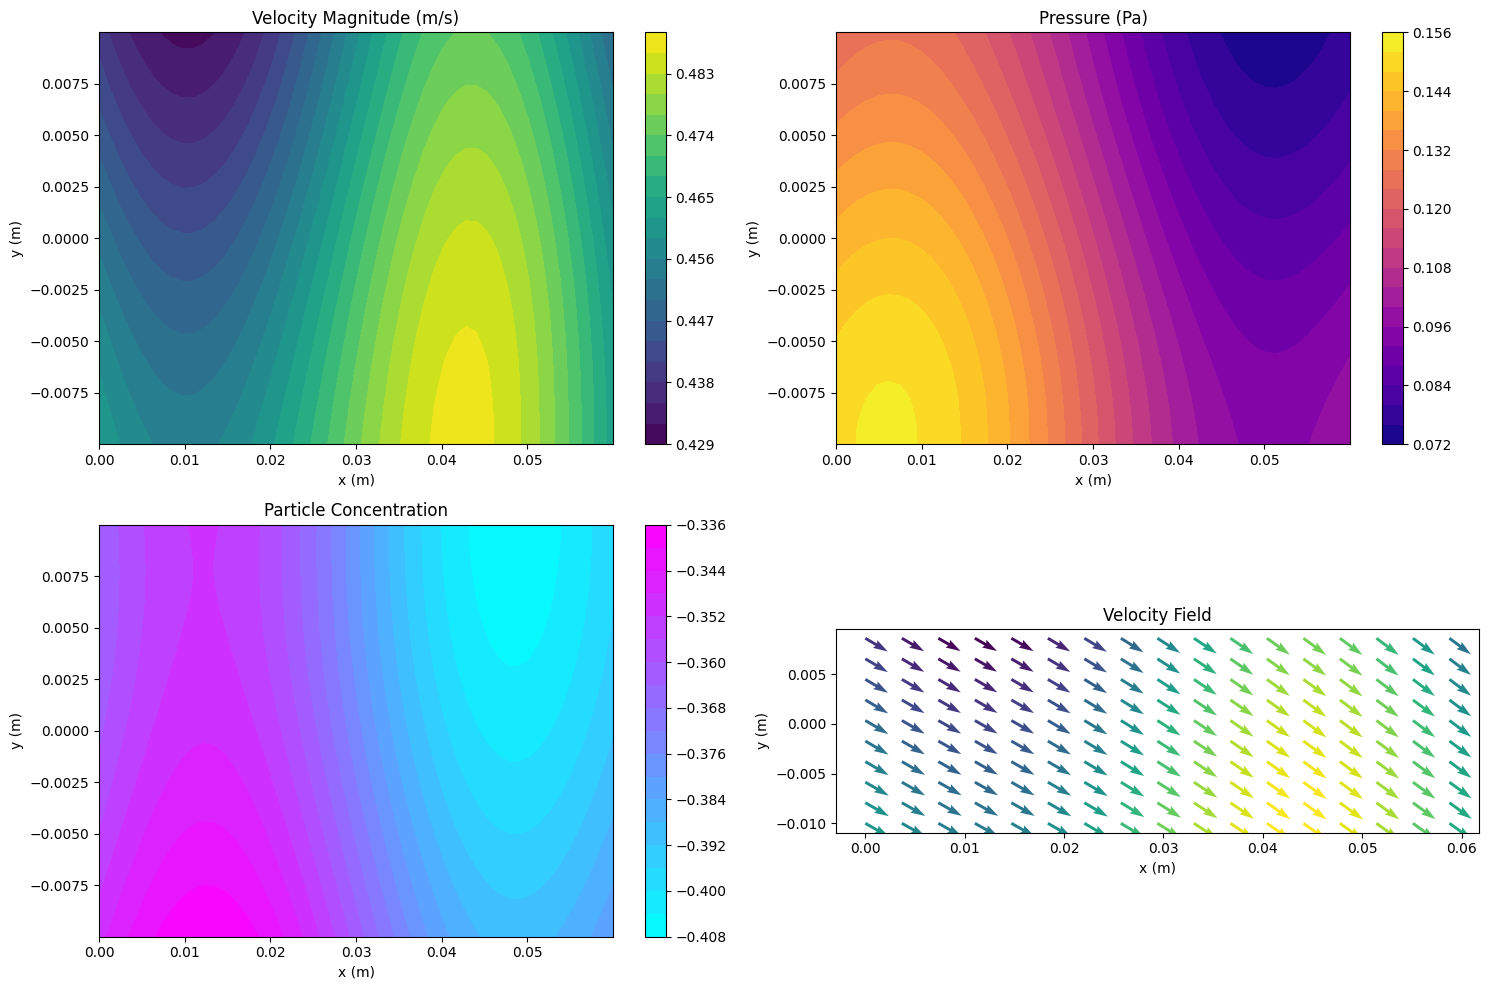

In [9]:
# Now run the visualization
visualize_results(model, cond)